In [2]:
import numpy as np

from dmipy.core.acquisition_scheme import acquisition_scheme_from_bvalues
from dmipy.signal_models import cylinder_models, gaussian_models
from dmipy.core.modeling_framework import MultiCompartmentModel

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as utils
from tqdm import tqdm

import process_data
import network
import config

In [3]:
normalized_scan_100206_full = np.load(config.norm_data_path + '/normalized_scan_100206_full.npy')

normalized_scan_val_set_full = np.load('normalized_scan_100610_full.npy')

In [4]:
bvals_all_100206 = np.loadtxt(config.data_folder2 + '/100206/bvals') * 1e-3
bvals_all_val_set = np.loadtxt(config.data_folder2 + '/100610/bvals') * 1e-3

In [5]:
big_b_indices_100206 = np.where(bvals_all_100206 != 0.005)[0]
big_b_indices_val_set = np.where(bvals_all_val_set != 0.005)[0]

In [6]:
bvals_100206 = bvals_all_100206[big_b_indices_100206]
bvals_val_set = bvals_all_100206[big_b_indices_val_set]

In [7]:
normalized_scan_100206_no_b5 = normalized_scan_100206_full[:, big_b_indices_100206]
normalized_scan_val_set_no_b5 = normalized_scan_val_set_full[:, big_b_indices_val_set]

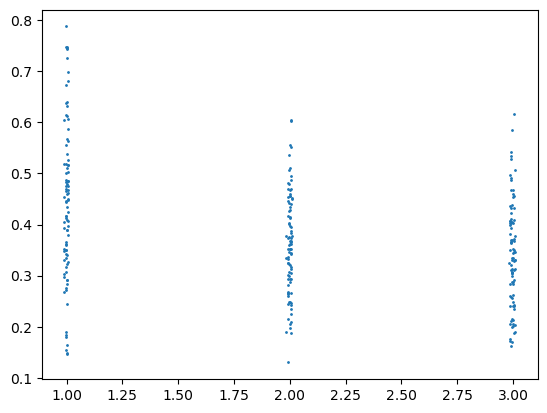

In [8]:
plt.plot(bvals_100206, normalized_scan_100206_no_b5[42,:], "o", markersize = 1)
# plt.plot(bvals_val_set, normalized_scan_val_set_no_b5[42,:], "o", markersize = 1)

In [9]:
n_100206_all = np.loadtxt(config.data_folder2 + '/100206/bvecs')

n_val_set_all = np.loadtxt(config.data_folder2 + '/100610/bvecs')

In [10]:
n_100206 = n_100206_all[:,big_b_indices_100206].T
print(n_100206.shape)

b_values_100206 = torch.FloatTensor(bvals_100206)
gradient_directions_100206 = torch.FloatTensor(n_100206)

n_val_set = n_val_set_all[:,big_b_indices_val_set].T
print(n_val_set.shape)

b_values_val_set = torch.FloatTensor(bvals_val_set)
gradient_directions_val_set = torch.FloatTensor(n_val_set)

(270, 3)
(270, 3)


In [11]:
batch_size = 128
num_batches = len(normalized_scan_100206_no_b5) // batch_size
trainloader = utils.DataLoader(torch.from_numpy(normalized_scan_100206_no_b5.astype(np.float32)),
                            batch_size = batch_size, 
                            shuffle = True,
                            num_workers = 2,
                            drop_last = True)

In [12]:
val_set = torch.from_numpy(normalized_scan_val_set_no_b5.astype(np.float32))
print(val_set.shape)
print(type(val_set))

torch.Size([880154, 270])
<class 'torch.Tensor'>


In [19]:
# net_golden_std = network.BallStickNet(gradient_directions_100206, b_values_100206)
# net_golden_std.load_state_dict(torch.load("/Users/weiwenhua/UGY4/COMP0029/COMP0029-Project/deep-ball-stick/model_100206_norm_01_Feb_182e.pt"))
# criterion = nn.MSELoss()
# optimizer = optim.Adam(net_golden_std.parameters(), lr = 0.00001)

net = network.BallStickNet(gradient_directions_100206, b_values_100206)

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr = 0.00001)

In [20]:
train_loss_list=[]
avg_train_loss_list=[]

val_loss_list = []
avg_val_loss_list=[]


# Best loss
best_train_loss = 1e16
best_val_loss = 1e16
num_bad_epochs_train = 0
num_bad_epochs_val = 0
patience = 20

for epoch in range(1000):
    print("-----------------------------------------------------------------")
    print("Epoch: {}; Bad training epochs: {}; Bad validation epochs: {}".format(epoch, num_bad_epochs_train, num_bad_epochs_val))
    net.train()
    running_train_loss = 0.
    
#     Training
    for i, X_batch in enumerate(tqdm(trainloader), 0):
        optimizer.zero_grad()
        X_pred, theta, phi, mu_cart_pred, lambda_par_pred, lambda_iso_pred, volume_0_pred, volume_1_pred = net(X_batch)
        loss = criterion(X_pred.type(torch.FloatTensor), X_batch.type(torch.FloatTensor))
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()
        
    train_loss_list.append(running_train_loss)
    avg_train_loss_list.append(running_train_loss/num_batches)
    print("Loss: {}; Average Loss: {}".format(running_train_loss, running_train_loss/num_batches))
    
#     Validation
    temp_model = net.state_dict()
    val_net = network.BallStickNet(gradient_directions_val_set, b_values_val_set)
    val_net.load_state_dict(temp_model)
    val_net.eval()
    with torch.no_grad():
        val_pred, _, _, _, _, _, _, _ = val_net(val_set)
        val_loss = criterion(val_pred.type(torch.FloatTensor), val_set.type(torch.FloatTensor))
        running_val_loss = val_loss.item()
        val_loss_list.append(running_val_loss)
        print("Validation Loss: {}".format(running_val_loss))

    if running_train_loss < best_train_loss:
        print("############### Saving good model for training set ###############################")
        final_model_trainset = net.state_dict()
        best_train_loss = running_train_loss
        num_bad_epochs_train = 0
        
        if running_val_loss < best_val_loss:
            print("############### Saving good model for validation set ###############################")
            final_model_valset = net.state_dict()
            best_val_loss = running_val_loss
            num_bad_epochs_val = 0
        else:
            if running_val_loss >= best_val_loss:
                num_bad_epochs_val += 1
    else:
        
        if running_train_loss >= best_train_loss:
            num_bad_epochs_train = num_bad_epochs_train + 1
            if num_bad_epochs_train == patience:
                print("Done, best training loss per epoch: {}; best validation loss: {}".format(best_train_loss, best_val_loss))
                break
        if running_val_loss >= best_val_loss:
            num_bad_epochs_val = num_bad_epochs_val + 1
            
        if running_val_loss < best_val_loss:
            best_val_loss = running_val_loss
            num_bad_epochs_val = 0
            print("ATTENTION: the loss on the train set is increasing while the loss on the validation set is decreasing. ")

            
print("Done") 
net.load_state_dict(final_model_trainset)
net.load_state_dict(final_model_valset)

-----------------------------------------------------------------
Epoch: 0; Bad training epochs: 0; Bad validation epochs: 0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:16<00:00, 95.13it/s]


Loss: 511.8854932896793; Average Loss: 0.0700445393116693
Validation Loss: 0.1299947053194046
############### Saving good model for training set ###############################
############### Saving good model for validation set ###############################
-----------------------------------------------------------------
Epoch: 1; Bad training epochs: 0; Bad validation epochs: 0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:21<00:00, 89.97it/s]


Loss: 427.40542918257415; Average Loss: 0.058484596220932425
Validation Loss: 0.1299065202474594
############### Saving good model for training set ###############################
############### Saving good model for validation set ###############################
-----------------------------------------------------------------
Epoch: 2; Bad training epochs: 0; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:07<00:00, 109.01it/s]


Loss: 425.4831663335208; Average Loss: 0.05822156080097438
Validation Loss: 0.12955674529075623
############### Saving good model for training set ###############################
############### Saving good model for validation set ###############################
-----------------------------------------------------------------
Epoch: 3; Bad training epochs: 0; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:07<00:00, 107.92it/s]


Loss: 424.690059609944; Average Loss: 0.058113034976730156
Validation Loss: 0.1294330209493637
############### Saving good model for training set ###############################
############### Saving good model for validation set ###############################
-----------------------------------------------------------------
Epoch: 4; Bad training epochs: 0; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:53<00:00, 136.51it/s]


Loss: 423.2703521531075; Average Loss: 0.05791876739916633
Validation Loss: 0.12943217158317566
############### Saving good model for training set ###############################
############### Saving good model for validation set ###############################
-----------------------------------------------------------------
Epoch: 5; Bad training epochs: 0; Bad validation epochs: 0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:19<00:00, 91.94it/s]


Loss: 422.9477045806125; Average Loss: 0.05787461748503181
Validation Loss: 0.1295289397239685
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 6; Bad training epochs: 0; Bad validation epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:10<00:00, 102.94it/s]


Loss: 422.34796363138594; Average Loss: 0.05779255112635275
Validation Loss: 0.12918882071971893
############### Saving good model for training set ###############################
############### Saving good model for validation set ###############################
-----------------------------------------------------------------
Epoch: 7; Bad training epochs: 0; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:00<00:00, 121.51it/s]


Loss: 421.71211389964446; Average Loss: 0.05770554377389771
Validation Loss: 0.1297616809606552
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 8; Bad training epochs: 0; Bad validation epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:08<00:00, 107.47it/s]


Loss: 420.79544188501313; Average Loss: 0.057580109727013294
Validation Loss: 0.1293657273054123
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 9; Bad training epochs: 0; Bad validation epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:59<00:00, 123.45it/s]


Loss: 420.6230219716672; Average Loss: 0.05755651641648429
Validation Loss: 0.12930254638195038
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 10; Bad training epochs: 0; Bad validation epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:47<00:00, 154.05it/s]


Loss: 420.5262333438732; Average Loss: 0.05754327221454203
Validation Loss: 0.12927980720996857
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 11; Bad training epochs: 0; Bad validation epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:47<00:00, 152.68it/s]


Loss: 420.2259995173663; Average Loss: 0.05750218931545789
Validation Loss: 0.1294548660516739
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 12; Bad training epochs: 0; Bad validation epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:55<00:00, 131.55it/s]


Loss: 420.13495861086994; Average Loss: 0.057489731610682805
Validation Loss: 0.1292850524187088
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 13; Bad training epochs: 0; Bad validation epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:05<00:00, 110.90it/s]


Loss: 419.2094090040773; Average Loss: 0.05736308278654589
Validation Loss: 0.12904180586338043
############### Saving good model for training set ###############################
############### Saving good model for validation set ###############################
-----------------------------------------------------------------
Epoch: 14; Bad training epochs: 0; Bad validation epochs: 0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:21<00:00, 90.13it/s]


Loss: 419.85248839715496; Average Loss: 0.057451079419424594
Validation Loss: 0.12920905649662018
-----------------------------------------------------------------
Epoch: 15; Bad training epochs: 1; Bad validation epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:06<00:00, 109.75it/s]


Loss: 419.451611018274; Average Loss: 0.0573962248246133
Validation Loss: 0.1292712539434433
-----------------------------------------------------------------
Epoch: 16; Bad training epochs: 2; Bad validation epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:08<00:00, 106.61it/s]


Loss: 419.1725282149855; Average Loss: 0.057358036154212574
Validation Loss: 0.12904468178749084
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 17; Bad training epochs: 0; Bad validation epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:05<00:00, 111.37it/s]


Loss: 419.2594358418137; Average Loss: 0.057369928276110246
Validation Loss: 0.1288200318813324
ATTENTION: the loss on the train set is increasing while the loss on the validation set is decreasing. 
-----------------------------------------------------------------
Epoch: 18; Bad training epochs: 1; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:07<00:00, 108.66it/s]


Loss: 418.05214946507476; Average Loss: 0.05720472762247876
Validation Loss: 0.12903809547424316
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 19; Bad training epochs: 0; Bad validation epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:02<00:00, 116.50it/s]


Loss: 418.6750833662227; Average Loss: 0.05728996761989911
Validation Loss: 0.12899525463581085
-----------------------------------------------------------------
Epoch: 20; Bad training epochs: 1; Bad validation epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:48<00:00, 149.79it/s]


Loss: 417.52194156777114; Average Loss: 0.057132175912393425
Validation Loss: 0.12899154424667358
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 21; Bad training epochs: 0; Bad validation epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:46<00:00, 155.50it/s]


Loss: 417.5707724841777; Average Loss: 0.05713885775645563
Validation Loss: 0.12911760807037354
-----------------------------------------------------------------
Epoch: 22; Bad training epochs: 1; Bad validation epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 159.59it/s]


Loss: 417.52027529478073; Average Loss: 0.057131947905689755
Validation Loss: 0.12871740758419037
############### Saving good model for training set ###############################
############### Saving good model for validation set ###############################
-----------------------------------------------------------------
Epoch: 23; Bad training epochs: 0; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:46<00:00, 156.17it/s]


Loss: 417.1194430689793; Average Loss: 0.05707709948946077
Validation Loss: 0.12889082729816437
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 24; Bad training epochs: 0; Bad validation epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:05<00:00, 111.80it/s]


Loss: 416.9677470617462; Average Loss: 0.05705634196247211
Validation Loss: 0.12885822355747223
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 25; Bad training epochs: 0; Bad validation epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 164.88it/s]


Loss: 417.39468135661446; Average Loss: 0.057114762090396065
Validation Loss: 0.12879729270935059
-----------------------------------------------------------------
Epoch: 26; Bad training epochs: 1; Bad validation epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:46<00:00, 155.63it/s]


Loss: 416.3707834985107; Average Loss: 0.056974655651137206
Validation Loss: 0.1287968009710312
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 27; Bad training epochs: 0; Bad validation epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:02<00:00, 116.98it/s]


Loss: 415.46330519369803; Average Loss: 0.056850479637889716
Validation Loss: 0.12890468537807465
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 28; Bad training epochs: 0; Bad validation epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:01<00:00, 119.53it/s]


Loss: 415.5876192394644; Average Loss: 0.056867490317387026
Validation Loss: 0.1285337507724762
ATTENTION: the loss on the train set is increasing while the loss on the validation set is decreasing. 
-----------------------------------------------------------------
Epoch: 29; Bad training epochs: 1; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:01<00:00, 118.99it/s]


Loss: 414.0793320930097; Average Loss: 0.05666110181896685
Validation Loss: 0.1284753829240799
############### Saving good model for training set ###############################
############### Saving good model for validation set ###############################
-----------------------------------------------------------------
Epoch: 30; Bad training epochs: 0; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:55<00:00, 131.66it/s]


Loss: 413.58647022536024; Average Loss: 0.05659366040303233
Validation Loss: 0.12825153768062592
############### Saving good model for training set ###############################
############### Saving good model for validation set ###############################
-----------------------------------------------------------------
Epoch: 31; Bad training epochs: 0; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:47<00:00, 154.34it/s]


Loss: 413.0350500792265; Average Loss: 0.05651820608637473
Validation Loss: 0.12817518413066864
############### Saving good model for training set ###############################
############### Saving good model for validation set ###############################
-----------------------------------------------------------------
Epoch: 32; Bad training epochs: 0; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:48<00:00, 151.91it/s]


Loss: 413.01478138612583; Average Loss: 0.05651543259251859
Validation Loss: 0.12834736704826355
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 33; Bad training epochs: 0; Bad validation epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:49<00:00, 148.43it/s]


Loss: 412.58481763582677; Average Loss: 0.05645659792498998
Validation Loss: 0.12826217710971832
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 34; Bad training epochs: 0; Bad validation epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:52<00:00, 138.96it/s]


Loss: 412.93402657541446; Average Loss: 0.056504382399482
Validation Loss: 0.12814687192440033
ATTENTION: the loss on the train set is increasing while the loss on the validation set is decreasing. 
-----------------------------------------------------------------
Epoch: 35; Bad training epochs: 1; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:04<00:00, 112.98it/s]


Loss: 411.8114175214432; Average Loss: 0.056350768681095134
Validation Loss: 0.12835603952407837
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 36; Bad training epochs: 0; Bad validation epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:08<00:00, 107.11it/s]


Loss: 412.1197038749233; Average Loss: 0.05639295345852809
Validation Loss: 0.12824735045433044
-----------------------------------------------------------------
Epoch: 37; Bad training epochs: 1; Bad validation epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:52<00:00, 138.00it/s]


Loss: 412.1020040255971; Average Loss: 0.05639053147586168
Validation Loss: 0.12826114892959595
-----------------------------------------------------------------
Epoch: 38; Bad training epochs: 2; Bad validation epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:05<00:00, 111.70it/s]


Loss: 411.73927597375587; Average Loss: 0.05634089709547836
Validation Loss: 0.12818679213523865
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 39; Bad training epochs: 0; Bad validation epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:56<00:00, 128.60it/s]


Loss: 411.34377617784776; Average Loss: 0.056286778349459186
Validation Loss: 0.1284637153148651
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 40; Bad training epochs: 0; Bad validation epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:58<00:00, 124.53it/s]


Loss: 411.67414245195687; Average Loss: 0.05633198446250094
Validation Loss: 0.12819285690784454
-----------------------------------------------------------------
Epoch: 41; Bad training epochs: 1; Bad validation epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:02<00:00, 116.25it/s]


Loss: 411.39953499566764; Average Loss: 0.05629440818222053
Validation Loss: 0.12822885811328888
-----------------------------------------------------------------
Epoch: 42; Bad training epochs: 2; Bad validation epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:53<00:00, 136.66it/s]


Loss: 411.31691498332657; Average Loss: 0.056283102761812615
Validation Loss: 0.12806685268878937
############### Saving good model for training set ###############################
############### Saving good model for validation set ###############################
-----------------------------------------------------------------
Epoch: 43; Bad training epochs: 0; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:47<00:00, 153.29it/s]


Loss: 410.6069466685876; Average Loss: 0.05618595329345753
Validation Loss: 0.12826476991176605
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 44; Bad training epochs: 0; Bad validation epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:04<00:00, 112.68it/s]


Loss: 410.6965879073832; Average Loss: 0.056198219472822004
Validation Loss: 0.12827330827713013
-----------------------------------------------------------------
Epoch: 45; Bad training epochs: 1; Bad validation epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:59<00:00, 122.42it/s]


Loss: 410.46927247243; Average Loss: 0.05616711445982896
Validation Loss: 0.12828734517097473
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 46; Bad training epochs: 0; Bad validation epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:57<00:00, 126.24it/s]


Loss: 410.45006780000404; Average Loss: 0.056164486562671596
Validation Loss: 0.1281602680683136
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 47; Bad training epochs: 0; Bad validation epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:49<00:00, 147.89it/s]


Loss: 409.6451113859657; Average Loss: 0.05605433927011025
Validation Loss: 0.12803198397159576
############### Saving good model for training set ###############################
############### Saving good model for validation set ###############################
-----------------------------------------------------------------
Epoch: 48; Bad training epochs: 0; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 163.85it/s]


Loss: 409.83143649599515; Average Loss: 0.05607983531691231
Validation Loss: 0.12833087146282196
-----------------------------------------------------------------
Epoch: 49; Bad training epochs: 1; Bad validation epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:47<00:00, 155.02it/s]


Loss: 409.4385782869067; Average Loss: 0.056026078035975195
Validation Loss: 0.1280675232410431
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 50; Bad training epochs: 0; Bad validation epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:48<00:00, 149.75it/s]


Loss: 409.17144425818697; Average Loss: 0.05598952439219854
Validation Loss: 0.12794451415538788
############### Saving good model for training set ###############################
############### Saving good model for validation set ###############################
-----------------------------------------------------------------
Epoch: 51; Bad training epochs: 0; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:48<00:00, 150.80it/s]


Loss: 408.6378682672512; Average Loss: 0.055916511804495236
Validation Loss: 0.12811985611915588
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 52; Bad training epochs: 0; Bad validation epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 165.37it/s]


Loss: 408.5888898698613; Average Loss: 0.05590980977967451
Validation Loss: 0.1281295120716095
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 53; Bad training epochs: 0; Bad validation epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:48<00:00, 150.79it/s]


Loss: 408.528109642677; Average Loss: 0.05590149283561535
Validation Loss: 0.12800639867782593
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 54; Bad training epochs: 0; Bad validation epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 162.11it/s]


Loss: 407.8704163527582; Average Loss: 0.055811496490525206
Validation Loss: 0.12804678082466125
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 55; Bad training epochs: 0; Bad validation epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 164.98it/s]


Loss: 408.2107381634414; Average Loss: 0.05585806488279166
Validation Loss: 0.12805546820163727
-----------------------------------------------------------------
Epoch: 56; Bad training epochs: 1; Bad validation epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:46<00:00, 158.39it/s]


Loss: 407.8049762302544; Average Loss: 0.05580254190342835
Validation Loss: 0.12795323133468628
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 57; Bad training epochs: 0; Bad validation epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:55<00:00, 131.08it/s]


Loss: 407.55290332832374; Average Loss: 0.05576804916917402
Validation Loss: 0.1277538388967514
############### Saving good model for training set ###############################
############### Saving good model for validation set ###############################
-----------------------------------------------------------------
Epoch: 58; Bad training epochs: 0; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:51<00:00, 142.79it/s]


Loss: 407.3631618376821; Average Loss: 0.05574208563734019
Validation Loss: 0.12795676290988922
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 59; Bad training epochs: 0; Bad validation epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:49<00:00, 146.50it/s]


Loss: 406.94077898189425; Average Loss: 0.05568428831169872
Validation Loss: 0.12767015397548676
############### Saving good model for training set ###############################
############### Saving good model for validation set ###############################
-----------------------------------------------------------------
Epoch: 60; Bad training epochs: 0; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 161.85it/s]


Loss: 406.67989235324785; Average Loss: 0.055648589539305945
Validation Loss: 0.12808656692504883
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 61; Bad training epochs: 0; Bad validation epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:47<00:00, 154.64it/s]


Loss: 407.146949992748; Average Loss: 0.05571249999900766
Validation Loss: 0.12792949378490448
-----------------------------------------------------------------
Epoch: 62; Bad training epochs: 1; Bad validation epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:47<00:00, 152.64it/s]


Loss: 406.9380593181122; Average Loss: 0.0556839161628506
Validation Loss: 0.12767039239406586
-----------------------------------------------------------------
Epoch: 63; Bad training epochs: 2; Bad validation epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:49<00:00, 146.68it/s]


Loss: 406.6532251466997; Average Loss: 0.055644940496264325
Validation Loss: 0.12779046595096588
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 64; Bad training epochs: 0; Bad validation epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:48<00:00, 150.40it/s]


Loss: 406.5375815057196; Average Loss: 0.05562911624325664
Validation Loss: 0.12815317511558533
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 65; Bad training epochs: 0; Bad validation epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:52<00:00, 139.59it/s]


Loss: 406.3895981123205; Average Loss: 0.055608866736770735
Validation Loss: 0.1278059184551239
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 66; Bad training epochs: 0; Bad validation epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:54<00:00, 134.03it/s]


Loss: 406.49565096455626; Average Loss: 0.05562337862131312
Validation Loss: 0.1276899129152298
-----------------------------------------------------------------
Epoch: 67; Bad training epochs: 1; Bad validation epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:50<00:00, 144.90it/s]


Loss: 406.25583457923494; Average Loss: 0.05559056302397851
Validation Loss: 0.12770983576774597
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 68; Bad training epochs: 0; Bad validation epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:49<00:00, 147.72it/s]


Loss: 406.18979593599215; Average Loss: 0.055581526537492085
Validation Loss: 0.1275002509355545
############### Saving good model for training set ###############################
############### Saving good model for validation set ###############################
-----------------------------------------------------------------
Epoch: 69; Bad training epochs: 0; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:51<00:00, 142.87it/s]


Loss: 406.14039812702686; Average Loss: 0.055574767121924856
Validation Loss: 0.12755228579044342
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 70; Bad training epochs: 0; Bad validation epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:53<00:00, 137.84it/s]


Loss: 405.93849854543805; Average Loss: 0.055547139921379045
Validation Loss: 0.1276663839817047
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 71; Bad training epochs: 0; Bad validation epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:07<00:00, 108.98it/s]


Loss: 405.91039374191314; Average Loss: 0.055543294162823366
Validation Loss: 0.12766872346401215
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 72; Bad training epochs: 0; Bad validation epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:49<00:00, 148.40it/s]


Loss: 405.8374137196224; Average Loss: 0.055533307843407556
Validation Loss: 0.12758098542690277
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 73; Bad training epochs: 0; Bad validation epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:02<00:00, 117.59it/s]


Loss: 405.8324440836441; Average Loss: 0.055532627816590595
Validation Loss: 0.12775039672851562
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 74; Bad training epochs: 0; Bad validation epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:56<00:00, 128.61it/s]


Loss: 405.4283784199506; Average Loss: 0.055477336948542774
Validation Loss: 0.12778909504413605
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 75; Bad training epochs: 0; Bad validation epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:48<00:00, 149.15it/s]


Loss: 405.127849627519; Average Loss: 0.055436213687399975
Validation Loss: 0.1275804191827774
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 76; Bad training epochs: 0; Bad validation epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:59<00:00, 123.23it/s]


Loss: 405.1564562607091; Average Loss: 0.05544012811449221
Validation Loss: 0.12751242518424988
-----------------------------------------------------------------
Epoch: 77; Bad training epochs: 1; Bad validation epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:53<00:00, 136.99it/s]


Loss: 405.3529359388631; Average Loss: 0.05546701367526862
Validation Loss: 0.12770257890224457
-----------------------------------------------------------------
Epoch: 78; Bad training epochs: 2; Bad validation epochs: 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:53<00:00, 136.79it/s]


Loss: 405.4542976845987; Average Loss: 0.05548088364594947
Validation Loss: 0.1276295781135559
-----------------------------------------------------------------
Epoch: 79; Bad training epochs: 3; Bad validation epochs: 10


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:58<00:00, 124.23it/s]


Loss: 405.3275956849102; Average Loss: 0.055463546207568444
Validation Loss: 0.12743397057056427
ATTENTION: the loss on the train set is increasing while the loss on the validation set is decreasing. 
-----------------------------------------------------------------
Epoch: 80; Bad training epochs: 4; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:54<00:00, 133.87it/s]


Loss: 405.2160234679468; Average Loss: 0.055448279073337
Validation Loss: 0.12753383815288544
-----------------------------------------------------------------
Epoch: 81; Bad training epochs: 5; Bad validation epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:53<00:00, 137.38it/s]


Loss: 405.15710862656124; Average Loss: 0.0554402173818502
Validation Loss: 0.12758071720600128
-----------------------------------------------------------------
Epoch: 82; Bad training epochs: 6; Bad validation epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:49<00:00, 147.10it/s]


Loss: 404.59341858373955; Average Loss: 0.05536308409739184
Validation Loss: 0.12748320400714874
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 83; Bad training epochs: 0; Bad validation epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:49<00:00, 146.19it/s]


Loss: 404.6419845134951; Average Loss: 0.05536972968164958
Validation Loss: 0.12762409448623657
-----------------------------------------------------------------
Epoch: 84; Bad training epochs: 1; Bad validation epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:06<00:00, 110.21it/s]


Loss: 404.9203763466794; Average Loss: 0.05540782380222761
Validation Loss: 0.12762100994586945
-----------------------------------------------------------------
Epoch: 85; Bad training epochs: 2; Bad validation epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:59<00:00, 122.63it/s]


Loss: 404.7997469881084; Average Loss: 0.055391317321853914
Validation Loss: 0.12750104069709778
-----------------------------------------------------------------
Epoch: 86; Bad training epochs: 3; Bad validation epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:05<00:00, 111.40it/s]


Loss: 404.99797048885375; Average Loss: 0.055418441500937846
Validation Loss: 0.12751035392284393
-----------------------------------------------------------------
Epoch: 87; Bad training epochs: 4; Bad validation epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:47<00:00, 155.33it/s]


Loss: 404.8600198987406; Average Loss: 0.05539956484657096
Validation Loss: 0.12734319269657135
ATTENTION: the loss on the train set is increasing while the loss on the validation set is decreasing. 
-----------------------------------------------------------------
Epoch: 88; Bad training epochs: 5; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:48<00:00, 152.25it/s]


Loss: 404.69068885128945; Average Loss: 0.05537639420515729
Validation Loss: 0.1276133954524994
-----------------------------------------------------------------
Epoch: 89; Bad training epochs: 6; Bad validation epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:55<00:00, 130.67it/s]


Loss: 404.81082035717554; Average Loss: 0.05539283256118987
Validation Loss: 0.12759023904800415
-----------------------------------------------------------------
Epoch: 90; Bad training epochs: 7; Bad validation epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:48<00:00, 151.39it/s]


Loss: 404.31786696007475; Average Loss: 0.05532537862069988
Validation Loss: 0.12733620405197144
############### Saving good model for training set ###############################
############### Saving good model for validation set ###############################
-----------------------------------------------------------------
Epoch: 91; Bad training epochs: 0; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 159.11it/s]


Loss: 404.59965150570497; Average Loss: 0.05536393698764436
Validation Loss: 0.12749065458774567
-----------------------------------------------------------------
Epoch: 92; Bad training epochs: 1; Bad validation epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:55<00:00, 131.26it/s]


Loss: 404.2913515162654; Average Loss: 0.05532175034431656
Validation Loss: 0.1273018717765808
############### Saving good model for training set ###############################
############### Saving good model for validation set ###############################
-----------------------------------------------------------------
Epoch: 93; Bad training epochs: 0; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:49<00:00, 147.81it/s]


Loss: 404.3243837368209; Average Loss: 0.05532627035260275
Validation Loss: 0.12755084037780762
-----------------------------------------------------------------
Epoch: 94; Bad training epochs: 1; Bad validation epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:52<00:00, 138.95it/s]


Loss: 404.5963318061549; Average Loss: 0.05536348273209564
Validation Loss: 0.12756390869617462
-----------------------------------------------------------------
Epoch: 95; Bad training epochs: 2; Bad validation epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:51<00:00, 142.74it/s]


Loss: 404.28210660628974; Average Loss: 0.055320485304637346
Validation Loss: 0.12758788466453552
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 96; Bad training epochs: 0; Bad validation epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:58<00:00, 125.09it/s]


Loss: 404.21321816998534; Average Loss: 0.05531105886288798
Validation Loss: 0.12735220789909363
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 97; Bad training epochs: 0; Bad validation epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:53<00:00, 135.34it/s]


Loss: 404.45007509714924; Average Loss: 0.05534346949878889
Validation Loss: 0.12749886512756348
-----------------------------------------------------------------
Epoch: 98; Bad training epochs: 1; Bad validation epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:46<00:00, 157.46it/s]


Loss: 404.2004716473166; Average Loss: 0.05530931467533068
Validation Loss: 0.1273786723613739
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 99; Bad training epochs: 0; Bad validation epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:50<00:00, 143.91it/s]


Loss: 404.05256988480687; Average Loss: 0.0552890763389172
Validation Loss: 0.12761278450489044
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 100; Bad training epochs: 0; Bad validation epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:48<00:00, 150.96it/s]


Loss: 404.45133774378337; Average Loss: 0.05534364227473774
Validation Loss: 0.1275242418050766
-----------------------------------------------------------------
Epoch: 101; Bad training epochs: 1; Bad validation epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 172.38it/s]


Loss: 404.0023025099654; Average Loss: 0.055282197935134836
Validation Loss: 0.12747272849082947
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 102; Bad training epochs: 0; Bad validation epochs: 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:52<00:00, 140.18it/s]


Loss: 403.8855075610336; Average Loss: 0.05526621614135654
Validation Loss: 0.12745819985866547
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 103; Bad training epochs: 0; Bad validation epochs: 10


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:52<00:00, 137.98it/s]


Loss: 403.7129651217256; Average Loss: 0.055242606064822876
Validation Loss: 0.1273345649242401
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 104; Bad training epochs: 0; Bad validation epochs: 11


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:50<00:00, 143.86it/s]


Loss: 404.0853192883078; Average Loss: 0.0552935576475517
Validation Loss: 0.12742722034454346
-----------------------------------------------------------------
Epoch: 105; Bad training epochs: 1; Bad validation epochs: 12


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:48<00:00, 150.52it/s]


Loss: 403.83488950459287; Average Loss: 0.055259289751586324
Validation Loss: 0.12749409675598145
-----------------------------------------------------------------
Epoch: 106; Bad training epochs: 2; Bad validation epochs: 13


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:55<00:00, 130.87it/s]


Loss: 403.9403247523587; Average Loss: 0.05527371712539118
Validation Loss: 0.12727898359298706
ATTENTION: the loss on the train set is increasing while the loss on the validation set is decreasing. 
-----------------------------------------------------------------
Epoch: 107; Bad training epochs: 3; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:55<00:00, 131.93it/s]


Loss: 403.68981713731773; Average Loss: 0.05523943857927172
Validation Loss: 0.12732234597206116
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 108; Bad training epochs: 0; Bad validation epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:57<00:00, 126.46it/s]


Loss: 403.8399424208328; Average Loss: 0.05525998117416979
Validation Loss: 0.1274334043264389
-----------------------------------------------------------------
Epoch: 109; Bad training epochs: 1; Bad validation epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:50<00:00, 145.03it/s]


Loss: 404.1035445125308; Average Loss: 0.055296051520598084
Validation Loss: 0.12763316929340363
-----------------------------------------------------------------
Epoch: 110; Bad training epochs: 2; Bad validation epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:47<00:00, 155.41it/s]


Loss: 403.9740271824412; Average Loss: 0.05527832884269858
Validation Loss: 0.12753437459468842
-----------------------------------------------------------------
Epoch: 111; Bad training epochs: 3; Bad validation epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:46<00:00, 155.99it/s]


Loss: 403.86605926207267; Average Loss: 0.055263554907234905
Validation Loss: 0.12736693024635315
-----------------------------------------------------------------
Epoch: 112; Bad training epochs: 4; Bad validation epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:50<00:00, 145.73it/s]


Loss: 403.82907468732446; Average Loss: 0.05525849407325184
Validation Loss: 0.12733949720859528
-----------------------------------------------------------------
Epoch: 113; Bad training epochs: 5; Bad validation epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:46<00:00, 156.99it/s]


Loss: 403.834885887336; Average Loss: 0.05525928925661412
Validation Loss: 0.12759341299533844
-----------------------------------------------------------------
Epoch: 114; Bad training epochs: 6; Bad validation epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:49<00:00, 146.90it/s]


Loss: 403.81641651620157; Average Loss: 0.05525676197539704
Validation Loss: 0.1275656521320343
-----------------------------------------------------------------
Epoch: 115; Bad training epochs: 7; Bad validation epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:48<00:00, 150.68it/s]


Loss: 403.6893493917305; Average Loss: 0.055239374574675766
Validation Loss: 0.12746766209602356
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 116; Bad training epochs: 0; Bad validation epochs: 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:48<00:00, 151.73it/s]


Loss: 403.9419177910313; Average Loss: 0.055273935110978556
Validation Loss: 0.1275274157524109
-----------------------------------------------------------------
Epoch: 117; Bad training epochs: 1; Bad validation epochs: 10


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:50<00:00, 144.67it/s]


Loss: 403.86309734289534; Average Loss: 0.05526314960904424
Validation Loss: 0.1274399310350418
-----------------------------------------------------------------
Epoch: 118; Bad training epochs: 2; Bad validation epochs: 11


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:47<00:00, 153.42it/s]


Loss: 403.85040186392143; Average Loss: 0.055261412406119516
Validation Loss: 0.1273934543132782
-----------------------------------------------------------------
Epoch: 119; Bad training epochs: 3; Bad validation epochs: 12


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:50<00:00, 145.78it/s]


Loss: 403.7210418195464; Average Loss: 0.05524371125062211
Validation Loss: 0.12737548351287842
-----------------------------------------------------------------
Epoch: 120; Bad training epochs: 4; Bad validation epochs: 13


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:03<00:00, 115.55it/s]


Loss: 403.68504919623956; Average Loss: 0.05523878615164745
Validation Loss: 0.12747007608413696
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 121; Bad training epochs: 0; Bad validation epochs: 14


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:04<00:00, 112.86it/s]


Loss: 403.83824202930555; Average Loss: 0.05525974849881028
Validation Loss: 0.12727199494838715
ATTENTION: the loss on the train set is increasing while the loss on the validation set is decreasing. 
-----------------------------------------------------------------
Epoch: 122; Bad training epochs: 1; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:56<00:00, 130.15it/s]


Loss: 403.7360634373035; Average Loss: 0.05524576675387295
Validation Loss: 0.12743951380252838
-----------------------------------------------------------------
Epoch: 123; Bad training epochs: 2; Bad validation epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:49<00:00, 146.92it/s]


Loss: 403.5072204733733; Average Loss: 0.05521445271939974
Validation Loss: 0.12729975581169128
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 124; Bad training epochs: 0; Bad validation epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 159.29it/s]


Loss: 403.6458147452213; Average Loss: 0.05523341745282174
Validation Loss: 0.1273559331893921
-----------------------------------------------------------------
Epoch: 125; Bad training epochs: 1; Bad validation epochs: 3


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:17<00:00, 94.24it/s]


Loss: 403.51651897723787; Average Loss: 0.05521572509267075
Validation Loss: 0.12740759551525116
-----------------------------------------------------------------
Epoch: 126; Bad training epochs: 2; Bad validation epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:55<00:00, 130.89it/s]


Loss: 403.71955121844076; Average Loss: 0.05524350728221685
Validation Loss: 0.12726442515850067
ATTENTION: the loss on the train set is increasing while the loss on the validation set is decreasing. 
-----------------------------------------------------------------
Epoch: 127; Bad training epochs: 3; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:55<00:00, 130.56it/s]


Loss: 403.5424775800202; Average Loss: 0.055219277172963904
Validation Loss: 0.12729322910308838
-----------------------------------------------------------------
Epoch: 128; Bad training epochs: 4; Bad validation epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:10<00:00, 103.70it/s]


Loss: 403.52033030590974; Average Loss: 0.055216246620950975
Validation Loss: 0.12734554708003998
-----------------------------------------------------------------
Epoch: 129; Bad training epochs: 5; Bad validation epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:01<00:00, 119.38it/s]


Loss: 403.8417719840072; Average Loss: 0.0552602315249052
Validation Loss: 0.1273379772901535
-----------------------------------------------------------------
Epoch: 130; Bad training epochs: 6; Bad validation epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:52<00:00, 138.26it/s]


Loss: 403.44329425576143; Average Loss: 0.05520570528951306
Validation Loss: 0.12732739746570587
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 131; Bad training epochs: 0; Bad validation epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:59<00:00, 123.79it/s]


Loss: 403.4535523697268; Average Loss: 0.05520710897232168
Validation Loss: 0.12748456001281738
-----------------------------------------------------------------
Epoch: 132; Bad training epochs: 1; Bad validation epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:56<00:00, 129.33it/s]


Loss: 403.6188017653767; Average Loss: 0.055229721095426475
Validation Loss: 0.12740232050418854
-----------------------------------------------------------------
Epoch: 133; Bad training epochs: 2; Bad validation epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 164.30it/s]


Loss: 403.4386300300248; Average Loss: 0.05520506705391691
Validation Loss: 0.12757688760757446
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 134; Bad training epochs: 0; Bad validation epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 162.24it/s]


Loss: 403.457529818872; Average Loss: 0.05520765323192008
Validation Loss: 0.12737926840782166
-----------------------------------------------------------------
Epoch: 135; Bad training epochs: 1; Bad validation epochs: 8


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:15<00:00, 96.20it/s]


Loss: 403.5737578193657; Average Loss: 0.055223557446547035
Validation Loss: 0.12739849090576172
-----------------------------------------------------------------
Epoch: 136; Bad training epochs: 2; Bad validation epochs: 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:51<00:00, 142.21it/s]


Loss: 403.0434941898566; Average Loss: 0.055150998110270466
Validation Loss: 0.12722614407539368
############### Saving good model for training set ###############################
############### Saving good model for validation set ###############################
-----------------------------------------------------------------
Epoch: 137; Bad training epochs: 0; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:46<00:00, 158.28it/s]


Loss: 403.1945844772272; Average Loss: 0.05517167275276781
Validation Loss: 0.12751029431819916
-----------------------------------------------------------------
Epoch: 138; Bad training epochs: 1; Bad validation epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 160.82it/s]


Loss: 403.2610840864945; Average Loss: 0.05518077231615962
Validation Loss: 0.12732906639575958
-----------------------------------------------------------------
Epoch: 139; Bad training epochs: 2; Bad validation epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 159.96it/s]


Loss: 403.3620747041423; Average Loss: 0.05519459150302987
Validation Loss: 0.12741635739803314
-----------------------------------------------------------------
Epoch: 140; Bad training epochs: 3; Bad validation epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 166.72it/s]


Loss: 403.3330786868464; Average Loss: 0.055190623794040286
Validation Loss: 0.1274614781141281
-----------------------------------------------------------------
Epoch: 141; Bad training epochs: 4; Bad validation epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:51<00:00, 143.21it/s]


Loss: 403.44012196408585; Average Loss: 0.055205271204718916
Validation Loss: 0.12736061215400696
-----------------------------------------------------------------
Epoch: 142; Bad training epochs: 5; Bad validation epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:54<00:00, 135.31it/s]


Loss: 403.4996628270019; Average Loss: 0.05521341855870305
Validation Loss: 0.12746626138687134
-----------------------------------------------------------------
Epoch: 143; Bad training epochs: 6; Bad validation epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:48<00:00, 151.29it/s]


Loss: 402.9472091658972; Average Loss: 0.05513782281963563
Validation Loss: 0.12723790109157562
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 144; Bad training epochs: 0; Bad validation epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 174.65it/s]


Loss: 403.2948268991895; Average Loss: 0.055185389559276064
Validation Loss: 0.12724994122982025
-----------------------------------------------------------------
Epoch: 145; Bad training epochs: 1; Bad validation epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 169.09it/s]


Loss: 403.3766256957315; Average Loss: 0.05519658260751662
Validation Loss: 0.12740567326545715
-----------------------------------------------------------------
Epoch: 146; Bad training epochs: 2; Bad validation epochs: 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:05<00:00, 112.32it/s]


Loss: 403.0672409860417; Average Loss: 0.05515424753503581
Validation Loss: 0.12742449343204498
-----------------------------------------------------------------
Epoch: 147; Bad training epochs: 3; Bad validation epochs: 10


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:57<00:00, 127.09it/s]


Loss: 403.17117623751983; Average Loss: 0.05516846965483304
Validation Loss: 0.12735161185264587
-----------------------------------------------------------------
Epoch: 148; Bad training epochs: 4; Bad validation epochs: 11


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:48<00:00, 149.71it/s]


Loss: 403.1686150804162; Average Loss: 0.05516811919545925
Validation Loss: 0.12756600975990295
-----------------------------------------------------------------
Epoch: 149; Bad training epochs: 5; Bad validation epochs: 12


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:51<00:00, 142.88it/s]


Loss: 403.21550508844666; Average Loss: 0.055174535452715744
Validation Loss: 0.12726430594921112
-----------------------------------------------------------------
Epoch: 150; Bad training epochs: 6; Bad validation epochs: 13


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:50<00:00, 145.73it/s]


Loss: 402.96062873187475; Average Loss: 0.05513965910397848
Validation Loss: 0.12740185856819153
-----------------------------------------------------------------
Epoch: 151; Bad training epochs: 7; Bad validation epochs: 14


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:12<00:00, 101.00it/s]


Loss: 403.07341301767156; Average Loss: 0.055155092093277444
Validation Loss: 0.1271904706954956
ATTENTION: the loss on the train set is increasing while the loss on the validation set is decreasing. 
-----------------------------------------------------------------
Epoch: 152; Bad training epochs: 8; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:51<00:00, 142.06it/s]


Loss: 403.1960091397632; Average Loss: 0.0551718676983803
Validation Loss: 0.12767232954502106
-----------------------------------------------------------------
Epoch: 153; Bad training epochs: 9; Bad validation epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:48<00:00, 150.75it/s]


Loss: 403.19676854484715; Average Loss: 0.0551719716125954
Validation Loss: 0.1273280829191208
-----------------------------------------------------------------
Epoch: 154; Bad training epochs: 10; Bad validation epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 159.51it/s]


Loss: 403.01202467200346; Average Loss: 0.05514669193650841
Validation Loss: 0.12733282148838043
-----------------------------------------------------------------
Epoch: 155; Bad training epochs: 11; Bad validation epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:46<00:00, 156.26it/s]


Loss: 403.0971197481267; Average Loss: 0.055158336035594786
Validation Loss: 0.1273547261953354
-----------------------------------------------------------------
Epoch: 156; Bad training epochs: 12; Bad validation epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 163.22it/s]


Loss: 402.8532311115414; Average Loss: 0.05512496320628645
Validation Loss: 0.12729910016059875
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 157; Bad training epochs: 0; Bad validation epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:48<00:00, 149.16it/s]


Loss: 403.1212100102566; Average Loss: 0.055161632458984214
Validation Loss: 0.12719106674194336
-----------------------------------------------------------------
Epoch: 158; Bad training epochs: 1; Bad validation epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 169.13it/s]


Loss: 402.991070774151; Average Loss: 0.055143824681739326
Validation Loss: 0.1273704320192337
-----------------------------------------------------------------
Epoch: 159; Bad training epochs: 2; Bad validation epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:46<00:00, 158.77it/s]


Loss: 402.8748948688153; Average Loss: 0.055127927595623336
Validation Loss: 0.12726658582687378
-----------------------------------------------------------------
Epoch: 160; Bad training epochs: 3; Bad validation epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:49<00:00, 148.58it/s]


Loss: 402.92090550484136; Average Loss: 0.05513422352282996
Validation Loss: 0.1274452805519104
-----------------------------------------------------------------
Epoch: 161; Bad training epochs: 4; Bad validation epochs: 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:59<00:00, 123.04it/s]


Loss: 403.16361379926093; Average Loss: 0.055167434838431985
Validation Loss: 0.12747471034526825
-----------------------------------------------------------------
Epoch: 162; Bad training epochs: 5; Bad validation epochs: 10


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:55<00:00, 131.62it/s]


Loss: 403.0630802346859; Average Loss: 0.0551536781930331
Validation Loss: 0.1271892488002777
ATTENTION: the loss on the train set is increasing while the loss on the validation set is decreasing. 
-----------------------------------------------------------------
Epoch: 163; Bad training epochs: 6; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:49<00:00, 146.56it/s]


Loss: 402.9343592347577; Average Loss: 0.05513606448204129
Validation Loss: 0.12725390493869781
-----------------------------------------------------------------
Epoch: 164; Bad training epochs: 7; Bad validation epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:47<00:00, 152.49it/s]


Loss: 403.0679019340314; Average Loss: 0.055154337976742115
Validation Loss: 0.12727579474449158
-----------------------------------------------------------------
Epoch: 165; Bad training epochs: 8; Bad validation epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 169.11it/s]


Loss: 403.0317456785124; Average Loss: 0.055149390486933826
Validation Loss: 0.12740162014961243
-----------------------------------------------------------------
Epoch: 166; Bad training epochs: 9; Bad validation epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 170.97it/s]


Loss: 402.9374994263053; Average Loss: 0.055136494174371276
Validation Loss: 0.12740151584148407
-----------------------------------------------------------------
Epoch: 167; Bad training epochs: 10; Bad validation epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 167.84it/s]


Loss: 403.03843089938164; Average Loss: 0.05515030526811462
Validation Loss: 0.12734298408031464
-----------------------------------------------------------------
Epoch: 168; Bad training epochs: 11; Bad validation epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:49<00:00, 148.47it/s]


Loss: 402.91988845099695; Average Loss: 0.055134084352900514
Validation Loss: 0.12748052179813385
-----------------------------------------------------------------
Epoch: 169; Bad training epochs: 12; Bad validation epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:56<00:00, 129.00it/s]


Loss: 403.0142435100861; Average Loss: 0.055146995554198976
Validation Loss: 0.12732692062854767
-----------------------------------------------------------------
Epoch: 170; Bad training epochs: 13; Bad validation epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:09<00:00, 105.84it/s]


Loss: 402.9169813368935; Average Loss: 0.055133686554035784
Validation Loss: 0.12733867764472961
-----------------------------------------------------------------
Epoch: 171; Bad training epochs: 14; Bad validation epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:48<00:00, 150.55it/s]


Loss: 402.8835196199361; Average Loss: 0.05512910777503231
Validation Loss: 0.12733973562717438
-----------------------------------------------------------------
Epoch: 172; Bad training epochs: 15; Bad validation epochs: 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 162.93it/s]


Loss: 402.5924704482313; Average Loss: 0.05508928167052974
Validation Loss: 0.1273983269929886
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 173; Bad training epochs: 0; Bad validation epochs: 10


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:03<00:00, 115.75it/s]


Loss: 402.8815036879387; Average Loss: 0.05512883192226856
Validation Loss: 0.127625972032547
-----------------------------------------------------------------
Epoch: 174; Bad training epochs: 1; Bad validation epochs: 11


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:07<00:00, 109.00it/s]


Loss: 402.89606040809304; Average Loss: 0.05513082381063123
Validation Loss: 0.12728969752788544
-----------------------------------------------------------------
Epoch: 175; Bad training epochs: 2; Bad validation epochs: 12


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:56<00:00, 129.91it/s]


Loss: 402.6366913279053; Average Loss: 0.055095332694020976
Validation Loss: 0.12720701098442078
-----------------------------------------------------------------
Epoch: 176; Bad training epochs: 3; Bad validation epochs: 13


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:51<00:00, 141.02it/s]


Loss: 402.777216368122; Average Loss: 0.05511456162672715
Validation Loss: 0.1273408979177475
-----------------------------------------------------------------
Epoch: 177; Bad training epochs: 4; Bad validation epochs: 14


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 160.94it/s]


Loss: 402.80227094353177; Average Loss: 0.05511799000322
Validation Loss: 0.1274871975183487
-----------------------------------------------------------------
Epoch: 178; Bad training epochs: 5; Bad validation epochs: 15


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 163.56it/s]


Loss: 402.6942760795355; Average Loss: 0.05510321238088882
Validation Loss: 0.12736926972866058
-----------------------------------------------------------------
Epoch: 179; Bad training epochs: 6; Bad validation epochs: 16


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:47<00:00, 155.25it/s]


Loss: 402.9259073501453; Average Loss: 0.05513490795705327
Validation Loss: 0.12736661732196808
-----------------------------------------------------------------
Epoch: 180; Bad training epochs: 7; Bad validation epochs: 17


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 164.49it/s]


Loss: 402.69012179854326; Average Loss: 0.055102643924267
Validation Loss: 0.12722636759281158
-----------------------------------------------------------------
Epoch: 181; Bad training epochs: 8; Bad validation epochs: 18


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:47<00:00, 154.10it/s]


Loss: 402.8135656353552; Average Loss: 0.05511953552755271
Validation Loss: 0.12724612653255463
-----------------------------------------------------------------
Epoch: 182; Bad training epochs: 9; Bad validation epochs: 19


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:47<00:00, 153.48it/s]


Loss: 402.8096755144652; Average Loss: 0.055119003217633446
Validation Loss: 0.12735265493392944
-----------------------------------------------------------------
Epoch: 183; Bad training epochs: 10; Bad validation epochs: 20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 159.37it/s]


Loss: 402.5606507891789; Average Loss: 0.055084927584726176
Validation Loss: 0.12714777886867523
############### Saving good model for training set ###############################
############### Saving good model for validation set ###############################
-----------------------------------------------------------------
Epoch: 184; Bad training epochs: 0; Bad validation epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 167.79it/s]


Loss: 402.5727825325448; Average Loss: 0.05508658764813147
Validation Loss: 0.12725578248500824
-----------------------------------------------------------------
Epoch: 185; Bad training epochs: 1; Bad validation epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 166.66it/s]


Loss: 402.655299434904; Average Loss: 0.05509787895934647
Validation Loss: 0.12727731466293335
-----------------------------------------------------------------
Epoch: 186; Bad training epochs: 2; Bad validation epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:53<00:00, 136.09it/s]


Loss: 402.58978458400816; Average Loss: 0.05508891414668968
Validation Loss: 0.12723061442375183
-----------------------------------------------------------------
Epoch: 187; Bad training epochs: 3; Bad validation epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:54<00:00, 134.92it/s]


Loss: 402.7235659130383; Average Loss: 0.055107220294613894
Validation Loss: 0.12746286392211914
-----------------------------------------------------------------
Epoch: 188; Bad training epochs: 4; Bad validation epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:54<00:00, 134.15it/s]


Loss: 402.71724116266705; Average Loss: 0.055106354838898065
Validation Loss: 0.12728868424892426
-----------------------------------------------------------------
Epoch: 189; Bad training epochs: 5; Bad validation epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:47<00:00, 152.55it/s]


Loss: 402.804438008694; Average Loss: 0.05511828653649343
Validation Loss: 0.12729930877685547
-----------------------------------------------------------------
Epoch: 190; Bad training epochs: 6; Bad validation epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:46<00:00, 158.04it/s]


Loss: 402.45802422822453; Average Loss: 0.0550708845413553
Validation Loss: 0.12731648981571198
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 191; Bad training epochs: 0; Bad validation epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:51<00:00, 141.45it/s]


Loss: 402.6509124550503; Average Loss: 0.05509727866106326
Validation Loss: 0.12718696892261505
-----------------------------------------------------------------
Epoch: 192; Bad training epochs: 1; Bad validation epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 163.29it/s]


Loss: 402.71672859508544; Average Loss: 0.05510628470102428
Validation Loss: 0.12727989256381989
-----------------------------------------------------------------
Epoch: 193; Bad training epochs: 2; Bad validation epochs: 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 159.02it/s]


Loss: 402.5535220738966; Average Loss: 0.055083952117391435
Validation Loss: 0.1273009181022644
-----------------------------------------------------------------
Epoch: 194; Bad training epochs: 3; Bad validation epochs: 10


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:48<00:00, 152.21it/s]


Loss: 402.7457290450111; Average Loss: 0.05511025301655872
Validation Loss: 0.1274084448814392
-----------------------------------------------------------------
Epoch: 195; Bad training epochs: 4; Bad validation epochs: 11


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:46<00:00, 156.79it/s]


Loss: 402.7476656155195; Average Loss: 0.05511051800978647
Validation Loss: 0.12722080945968628
-----------------------------------------------------------------
Epoch: 196; Bad training epochs: 5; Bad validation epochs: 12


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:48<00:00, 151.82it/s]


Loss: 402.4430965145584; Average Loss: 0.05506884188759694
Validation Loss: 0.1272750198841095
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 197; Bad training epochs: 0; Bad validation epochs: 13


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:05<00:00, 112.14it/s]


Loss: 402.35818777093664; Average Loss: 0.05505722328556878
Validation Loss: 0.12715546786785126
############### Saving good model for training set ###############################
-----------------------------------------------------------------
Epoch: 198; Bad training epochs: 0; Bad validation epochs: 14


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:02<00:00, 116.01it/s]


Loss: 402.62168965279125; Average Loss: 0.0550932799196485
Validation Loss: 0.12738284468650818
-----------------------------------------------------------------
Epoch: 199; Bad training epochs: 1; Bad validation epochs: 15


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:52<00:00, 138.30it/s]


Loss: 402.5919290969614; Average Loss: 0.05508920759400129
Validation Loss: 0.12727713584899902
-----------------------------------------------------------------
Epoch: 200; Bad training epochs: 2; Bad validation epochs: 16


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:59<00:00, 123.27it/s]


Loss: 402.88643516507; Average Loss: 0.05512950672756842
Validation Loss: 0.12732385098934174
-----------------------------------------------------------------
Epoch: 201; Bad training epochs: 3; Bad validation epochs: 17


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:54<00:00, 133.63it/s]


Loss: 402.37413861532696; Average Loss: 0.0550594059407946
Validation Loss: 0.1273229718208313
-----------------------------------------------------------------
Epoch: 202; Bad training epochs: 4; Bad validation epochs: 18


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:53<00:00, 136.71it/s]


Loss: 402.6095111044124; Average Loss: 0.05509161345161636
Validation Loss: 0.12731918692588806
-----------------------------------------------------------------
Epoch: 203; Bad training epochs: 5; Bad validation epochs: 19


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:47<00:00, 152.28it/s]


Loss: 402.74771212018095; Average Loss: 0.055110524373314304
Validation Loss: 0.12736642360687256
-----------------------------------------------------------------
Epoch: 204; Bad training epochs: 6; Bad validation epochs: 20


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:00<00:00, 121.77it/s]


Loss: 402.54901775717735; Average Loss: 0.05508333576316056
Validation Loss: 0.1272815465927124
-----------------------------------------------------------------
Epoch: 205; Bad training epochs: 7; Bad validation epochs: 21


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:49<00:00, 147.16it/s]


Loss: 402.5988752692938; Average Loss: 0.05509015808282619
Validation Loss: 0.12735632061958313
-----------------------------------------------------------------
Epoch: 206; Bad training epochs: 8; Bad validation epochs: 22


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:55<00:00, 131.01it/s]


Loss: 402.43143069860525; Average Loss: 0.05506724557999525
Validation Loss: 0.12729410827159882
-----------------------------------------------------------------
Epoch: 207; Bad training epochs: 9; Bad validation epochs: 23


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:48<00:00, 149.17it/s]


Loss: 402.4493047648575; Average Loss: 0.05506969140186885
Validation Loss: 0.1272594928741455
-----------------------------------------------------------------
Epoch: 208; Bad training epochs: 10; Bad validation epochs: 24


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:53<00:00, 136.49it/s]


Loss: 402.3871107751038; Average Loss: 0.055061181003708784
Validation Loss: 0.12728308141231537
-----------------------------------------------------------------
Epoch: 209; Bad training epochs: 11; Bad validation epochs: 25


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:51<00:00, 143.21it/s]


Loss: 402.84219038067386; Average Loss: 0.0551234524330424
Validation Loss: 0.12733818590641022
-----------------------------------------------------------------
Epoch: 210; Bad training epochs: 12; Bad validation epochs: 26


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:53<00:00, 137.28it/s]


Loss: 402.54943032050505; Average Loss: 0.05508339221681788
Validation Loss: 0.1272004097700119
-----------------------------------------------------------------
Epoch: 211; Bad training epochs: 13; Bad validation epochs: 27


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:50<00:00, 144.34it/s]


Loss: 402.6690007173456; Average Loss: 0.055099753792740236
Validation Loss: 0.12724466621875763
-----------------------------------------------------------------
Epoch: 212; Bad training epochs: 14; Bad validation epochs: 28


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:54<00:00, 133.89it/s]


Loss: 402.65549977566116; Average Loss: 0.05509790637324318
Validation Loss: 0.12729321420192719
-----------------------------------------------------------------
Epoch: 213; Bad training epochs: 15; Bad validation epochs: 29


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:46<00:00, 156.92it/s]


Loss: 402.5843663515989; Average Loss: 0.0550881727355773
Validation Loss: 0.12716227769851685
-----------------------------------------------------------------
Epoch: 214; Bad training epochs: 16; Bad validation epochs: 30


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:50<00:00, 145.76it/s]


Loss: 402.4462489944417; Average Loss: 0.055069273261417855
Validation Loss: 0.12718434631824493
-----------------------------------------------------------------
Epoch: 215; Bad training epochs: 17; Bad validation epochs: 31


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 159.85it/s]


Loss: 402.5883778987918; Average Loss: 0.055088721661027885
Validation Loss: 0.1271762251853943
-----------------------------------------------------------------
Epoch: 216; Bad training epochs: 18; Bad validation epochs: 32


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:53<00:00, 137.33it/s]


Loss: 402.51360205188394; Average Loss: 0.05507848960753749
Validation Loss: 0.12729834020137787
-----------------------------------------------------------------
Epoch: 217; Bad training epochs: 19; Bad validation epochs: 33


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:49<00:00, 146.77it/s]


Loss: 402.5270986163523; Average Loss: 0.05508033642807229
Validation Loss: 0.12725365161895752
Done, best training loss per epoch: 402.35818777093664; best validation loss: 0.12714777886867523
Done


<All keys matched successfully>

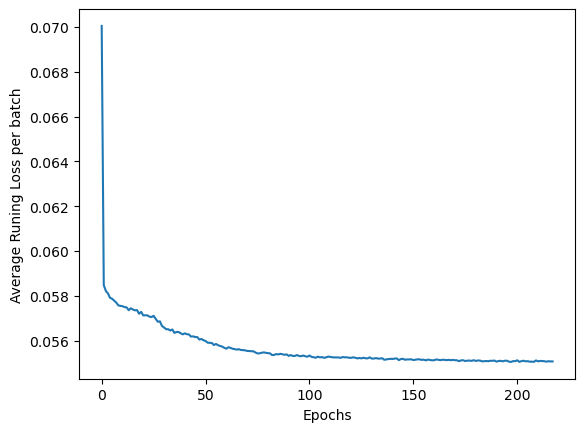

In [21]:

plt.plot(avg_train_loss_list)
plt.xlabel("Epochs")
plt.ylabel("Average Runing Loss per batch")
plt.show()

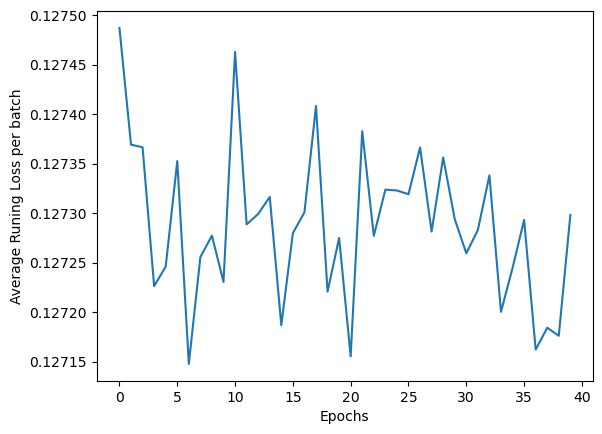

In [35]:
plt.plot(val_loss_list[217-40:217])
plt.xlabel("Epochs")
plt.ylabel("Average Runing Loss per batch")
plt.show()

In [30]:
with open('loss_golden_std.txt', 'w') as f:
    f.write('train_loss_per_epoch_list: ' + str(train_loss_list) + '\n')
    f.write('\n')
    f.write('avg_train_loss_list: ' + str(avg_train_loss_list) + '\n')
    f.write('\n')
    f.write('val_loss_list: ' + str(val_loss_list) + '\n')

In [31]:
len(val_loss_list[180:217])

218

In [32]:
torch.save(final_model_trainset, 'model_100206_golden_std_retrain_trainset.pt')
torch.save(final_model_valset, 'model_100206_golden_std_retrain_valset.pt')